In [2]:
import pandas as pd
import pandasql
from pandasql import sqldf
from datetime import date

save_result = 1

In [3]:
cycle_yr = '2010'
cycle_yr_abr = cycle_yr[2:4]
filepath_addit = "../raw data/oth"+ str(int(cycle_yr_abr)-2).zfill(2) + "/itoth" + str(int(cycle_yr)-2) + ".txt"
filepath_main = "../raw data/oth"+ cycle_yr_abr + "/itoth" + cycle_yr + ".txt"

In [4]:
colnm=['CMTE_ID','AMNDT_IND','RPT_TP','TRANSACTION_PGI','IMAGE_NUM','TRANSACTION_TP','ENTITY_TP','NAME','CITY','STATE',
       'ZIP_CODE','EMPLOYER','OCCUPATION','TRANSACTION_DT','TRANSACTION_AMT','OTHER_ID','TRAN_ID','FILE_NUM','MEMO_CD',
       'MEMO_TEXT','SUB_ID'
]
coltypes = {'CMTE_ID': str, 'AMNDT_IND':str, 'RPT_TP':str, 'TRANSACTION_PGI':str, 'IMAGE_NUM':str, 'TRANSACTION_TP':str, 
            'ENTITY_TP':str,'NAME':str, 'CITY':str, 'STATE':str, 'ZIP_CODE':str, 'EMPLOYER':str, 'OCCUPATION':str, 
            'TRANSACTION_DT':str, 'TRANSACTION_AMT':float, 'OTHER_ID':str, 'TRAN_ID':str, 'FILE_NUM':str, 'MEMO_CD':str, 
            'MEMO_TEXT':str, 'SUB_ID':str
           }
data_addit = pd.read_csv(filepath_addit, 
                    sep='|', header=None, names = colnm, dtype=coltypes)

In [5]:
print(data_addit.shape)
data_addit.head()

(693384, 21)


CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM TRANSACTION_TP  \
0  C00371021         A     Q2               P  27990778802            16C   
1  C00343863         N     Q3               P  27990795865            24K   
2  C00116632         N     Q3               P  27931382236            24K   
3  C00116632         N     Q3               P  27931382236            24K   
4  C00116632         N     Q3               P  27931382236            24K   

  ENTITY_TP                               NAME        CITY STATE  ...  \
0       CAN                    BRADLEY, JOSEPH   WOLFEBORO    NH  ...   
1       ORG               MICHIGAN REPUBLICANS     LANSING    MI  ...   
2       COM  NATIONAL REPUBLICAN CONGRESSIONAL  WASHINGTON    DC  ...   
3       COM  NATIONAL REPUBLICAN CONGRESSIONAL  WASHINGTON    DC  ...   
4       COM       REPUBLICAN PARTY OF KENTUCKY   FRANKFORT    KY  ...   

    EMPLOYER OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID  \
0  H2NH01130        NaN       06302007         10000.0  H2NH01130   
1        NaN        NaN       07232007         40000.0  C00041160   
2        NaN        NaN       08032007          2100.0  C00075820   
3        NaN        NaN       09052007         25000.0  C00075820   
4        NaN        NaN       07312007         25000.0  C00156810   

       TRAN_ID FILE_NUM MEMO_CD MEMO_TEXT               SUB_ID  
0  C-47-006M09   307028     NaN       NaN  4101520071081288342  
1    B-E-39500   307489     NaN       NaN  4101720071081637455  
2  D126-00521N   307500     NaN       NaN  4102220071081761789  
3  D127-00521O   307500     NaN       NaN  4102220071081761790  
4  D137-00B80F   307500     NaN       NaN  4102220071081761792  

[5 rows x 21 columns]

In [6]:
# Check if there are any negative values for image_num, there shouldn't be for 2008
# If the below returns true, then there is a problem because there a negative values for image_num
any(data_addit['IMAGE_NUM'].str[0]=='-')
# Okay note to self, can't convert the image_num to integers because there's letters in the image_num sometimes.

False

Okay now I'm going to filter it and save only the ones with transaction_pgi containing 2020 into their own dataframe.

In [27]:
explicitly_incycle_data_addit = data_addit[data_addit['TRANSACTION_PGI'].str.contains(cycle_yr, na=False)]
explicitly_incycle_data_addit

Empty DataFrame
Columns: [CMTE_ID, AMNDT_IND, RPT_TP, TRANSACTION_PGI, IMAGE_NUM, TRANSACTION_TP, ENTITY_TP, NAME, CITY, STATE, ZIP_CODE, EMPLOYER, OCCUPATION, TRANSACTION_DT, TRANSACTION_AMT, OTHER_ID, TRAN_ID, FILE_NUM, MEMO_CD, MEMO_TEXT, SUB_ID]
Index: []

[0 rows x 21 columns]

Using the election cycle dates, find any transaction that's not marked as in the election cycle but should be, and add those as well.
    I might have to do some extra research on how early before an election cycle starts, transactions can be made that count towards that.
* So, for the 2020 file, I will use the fact that the 2020 election cycle was [11-7-2018, 11-3-2020] and extract any transactions that (have a transaction_pgi containing 2020) OR (11-7-2018 <= transaction_dt <= 11-3-2020).
    * This is assuming that the dates in itoth2020 are actually from 2019 to 2020...I know from analyzing some of the other data that there are some weird records with like year 0 or year that's way later than it should be the data file.
    * Improvement Idea 1) a): Come back and investigate these weird dates, and decide what to do with them. For now, I'll just ignore them and not include them in my dataset.
    * Improvement Idea 1) b): Make sure that transactions for an election cycle can't take place before or after the election cycle dates...more of a boundary case
For now, I'll discard itoth2020.txt after I extract the 2020 election cycle. 
I can always redownload it from the FEC if I want to add in more records or do the 2020 election cycle, but rn it's taking up a lot of space on my computer.

In [28]:
data_addit[['TRANSACTION_DT']] = pd.to_datetime(data_addit['TRANSACTION_DT'], format='%m%d%Y').dt.date
data_addit[['TRANSACTION_DT']]

TRANSACTION_DT
0          2007-06-30
1          2007-07-23
2          2007-08-03
3          2007-09-05
4          2007-07-31
...               ...
693379     2008-10-09
693380     2008-10-10
693381     2008-10-09
693382     2008-10-09
693383     2008-10-09

[693384 rows x 1 columns]

Improvement Idea 1) d): Visualize the distribution of dates by histogramming it by years, then months for each year, then months, and days

## Don't forget to change the cycle dates!!!

In [29]:
startcyc = date(int(cycle_yr)-2,11,5) 
endcyc = date(int(cycle_yr),11,2) 
#greater than the start date and smaller than the end date
mask = (data_addit['TRANSACTION_DT'] >= startcyc) & (data_addit['TRANSACTION_DT'] <= endcyc)
includeby_date_addit_data = data_addit.loc[mask]
includeby_date_addit_data

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM  \
6495    C00385526         A     Q3               O  29020380929   
6496    C00385526         A     Q3               O  29020380929   
68988   C00167684         N     YE             NaN  28930097710   
164440  C90009861         A     YE               P  28039600454   
168368  C90004466         N     YE               P  28039630916   
...           ...       ...    ...             ...          ...   
681839  C00075820         A     YE             NaN  29991788832   
681840  C00075820         A     YE             NaN  29991788833   
681841  C00075820         A     YE             NaN  29991788833   
682151  C00407262         A     YE             NaN  29991788984   
682152  C00407262         A     YE             NaN  29991788984   

       TRANSACTION_TP ENTITY_TP  \
6495              18G       NaN   
6496              18G       NaN   
68988             24K       ORG   
164440            24E       IND   
168368            24E       NaN   
...               ...       ...   
681839            18K       PAC   
681840            18G       COM   
681841            18G       COM   
682151            24K       PAC   
682152            24K       PAC   

                                                   NAME           CITY STATE  \
6495                    2009 SENATORS CLASSIC COMMITTEE     ALEXANDRIA    VA   
6496                    2009 SENATORS CLASSIC COMMITTEE     ALEXANDRIA    VA   
68988                     PETE DOMENICI SENATE CAMPAIGN    ALBUQUERQUE    NM   
164440                                      JONES, GWEN  SAN FRANCISCO    CA   
168368                              KD MAILING SERVICES    LINCOLNWOOD    IL   
...                                                 ...            ...   ...   
681839                         WEYERHAEUSER COMPANY PAC     WASHINGTON    DC   
681840                2008 PRESIDENT'S DINNER COMMITTEE         MCLEAN    VA   
681841                     LANCE MYERS NEW JERSEY TRUST     ALEXANDRIA    VA   
682151      DEMOCRATIC PARTY OF THE SAN FERNANDO VALLEY        BURBANK    CA   
682152  LOS ANGELES COUNTY DEMOCRATIC CENTRAL COMMITTEE        BURBANK    CA   

        ... EMPLOYER OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID  \
6495    ...      NaN        NaN     2009-09-30          2382.0  C00461152   
6496    ...      NaN        NaN     2009-09-30         14277.0  C00461152   
68988   ...      NaN        NaN     2008-12-31         -1000.0  C00202648   
164440  ...      NaN        NaN     2008-12-06          5000.0  P80000748   
168368  ...      NaN        NaN     2008-12-20          1437.0  S6IL00151   
...     ...      ...        ...            ...             ...        ...   
681839  ...      NaN        NaN     2008-12-31          5000.0  C00007948   
681840  ...      NaN        NaN     2008-12-16          5693.0  C00449116   
681841  ...      NaN        NaN     2008-12-16            79.0  C00454355   
682151  ...      NaN        NaN     2008-12-28            75.0  C00326751   
682152  ...      NaN        NaN     2008-12-18           100.0  C00300731   

                     TRAN_ID FILE_NUM MEMO_CD  \
6495        SA10290748101739   438384       X   
6496        SA10290748101740   438384       X   
68988            80124.C3613   317142     NaN   
164440        F5702041111086   321138     NaN   
168368        F5702141055082   322310     NaN   
...                      ...      ...     ...   
681839         SA11.12843056   409281     NaN   
681840             SA12.08PD   409281     NaN   
681841            SA12.LMNJT   409281     NaN   
682151  SB230000000000622001   409282     NaN   
682152  SB230000000000621995   409282     NaN   

                                                MEMO_TEXT               SUB_ID  
6495    TRANSFERS FROM AFFIL./AUTH. NOTE: MEMOED 2ND Q...  1110920090001151405  
6496    TRANSFERS FROM AFFIL./AUTH. NOTE: MEMOED ON 2N...  1110920090001151406  
68988                                                 NaN  4021120

Improvement idea 2) Investigate the records that are within the 2020 election cycle transaction_dt, but are marked as P2018, which may be for the 2018 election cycle or it may be for the 2020 cycle, and the ones that are marked as G2018, which are probably not in the 2020 election cycle....for now I'll leave it as is but I should come back and fix this.

In [30]:
pd.merge(left=explicitly_incycle_data_addit, right=includeby_date_addit_data, left_on='SUB_ID', right_on='SUB_ID')

Empty DataFrame
Columns: [CMTE_ID_x, AMNDT_IND_x, RPT_TP_x, TRANSACTION_PGI_x, IMAGE_NUM_x, TRANSACTION_TP_x, ENTITY_TP_x, NAME_x, CITY_x, STATE_x, ZIP_CODE_x, EMPLOYER_x, OCCUPATION_x, TRANSACTION_DT_x, TRANSACTION_AMT_x, OTHER_ID_x, TRAN_ID_x, FILE_NUM_x, MEMO_CD_x, MEMO_TEXT_x, CMTE_ID_y, AMNDT_IND_y, RPT_TP_y, TRANSACTION_PGI_y, IMAGE_NUM_y, TRANSACTION_TP_y, ENTITY_TP_y, NAME_y, CITY_y, STATE_y, ZIP_CODE_y, EMPLOYER_y, OCCUPATION_y, TRANSACTION_DT_y, TRANSACTION_AMT_y, OTHER_ID_y, TRAN_ID_y, FILE_NUM_y, MEMO_CD_y, MEMO_TEXT_y, SUB_ID]
Index: []

[0 rows x 41 columns]

So there are 0 records that are in both.

In [31]:
import matplotlib.pyplot as plt
import matplotlib_venn as venn
from matplotlib_venn import venn2

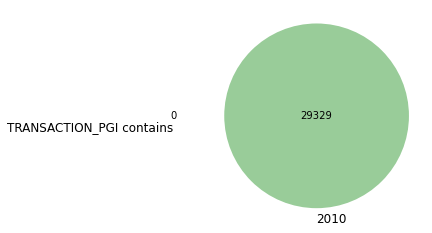

In [32]:
# Use the venn2 function
overlap = pd.merge(left=explicitly_incycle_data_addit, right=includeby_date_addit_data, left_on='SUB_ID', right_on='SUB_ID').shape[0]
# Find the number of rows of the ones that are explicitly included, and subtract from it the number that's in both
expincl_notin_dtrange = explicitly_incycle_data_addit.shape[0] - overlap
in_dtrange_not_expincl = includeby_date_addit_data.shape[0] - overlap
venn2(subsets = (expincl_notin_dtrange, in_dtrange_not_expincl , overlap), 
      set_labels = ('TRANSACTION_PGI contains', cycle_yr, 'TRANSACTION_DT in', cycle_yr, 'cycle date range'))
plt.show()

In [33]:
explicitly_incycle_data_additv2 = pd.concat([explicitly_incycle_data_addit, includeby_date_addit_data])
# Drop duplicates from the concatenated dataset
explicitly_incycle_data_additv2.drop_duplicates(subset=['SUB_ID'], inplace=True)
explicitly_incycle_data_additv2

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM  \
6495    C00385526         A     Q3               O  29020380929   
6496    C00385526         A     Q3               O  29020380929   
68988   C00167684         N     YE             NaN  28930097710   
164440  C90009861         A     YE               P  28039600454   
168368  C90004466         N     YE               P  28039630916   
...           ...       ...    ...             ...          ...   
681839  C00075820         A     YE             NaN  29991788832   
681840  C00075820         A     YE             NaN  29991788833   
681841  C00075820         A     YE             NaN  29991788833   
682151  C00407262         A     YE             NaN  29991788984   
682152  C00407262         A     YE             NaN  29991788984   

       TRANSACTION_TP ENTITY_TP  \
6495              18G       NaN   
6496              18G       NaN   
68988             24K       ORG   
164440            24E       IND   
168368            24E       NaN   
...               ...       ...   
681839            18K       PAC   
681840            18G       COM   
681841            18G       COM   
682151            24K       PAC   
682152            24K       PAC   

                                                   NAME           CITY STATE  \
6495                    2009 SENATORS CLASSIC COMMITTEE     ALEXANDRIA    VA   
6496                    2009 SENATORS CLASSIC COMMITTEE     ALEXANDRIA    VA   
68988                     PETE DOMENICI SENATE CAMPAIGN    ALBUQUERQUE    NM   
164440                                      JONES, GWEN  SAN FRANCISCO    CA   
168368                              KD MAILING SERVICES    LINCOLNWOOD    IL   
...                                                 ...            ...   ...   
681839                         WEYERHAEUSER COMPANY PAC     WASHINGTON    DC   
681840                2008 PRESIDENT'S DINNER COMMITTEE         MCLEAN    VA   
681841                     LANCE MYERS NEW JERSEY TRUST     ALEXANDRIA    VA   
682151      DEMOCRATIC PARTY OF THE SAN FERNANDO VALLEY        BURBANK    CA   
682152  LOS ANGELES COUNTY DEMOCRATIC CENTRAL COMMITTEE        BURBANK    CA   

        ... EMPLOYER OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID  \
6495    ...      NaN        NaN     2009-09-30          2382.0  C00461152   
6496    ...      NaN        NaN     2009-09-30         14277.0  C00461152   
68988   ...      NaN        NaN     2008-12-31         -1000.0  C00202648   
164440  ...      NaN        NaN     2008-12-06          5000.0  P80000748   
168368  ...      NaN        NaN     2008-12-20          1437.0  S6IL00151   
...     ...      ...        ...            ...             ...        ...   
681839  ...      NaN        NaN     2008-12-31          5000.0  C00007948   
681840  ...      NaN        NaN     2008-12-16          5693.0  C00449116   
681841  ...      NaN        NaN     2008-12-16            79.0  C00454355   
682151  ...      NaN        NaN     2008-12-28            75.0  C00326751   
682152  ...      NaN        NaN     2008-12-18           100.0  C00300731   

                     TRAN_ID FILE_NUM MEMO_CD  \
6495        SA10290748101739   438384       X   
6496        SA10290748101740   438384       X   
68988            80124.C3613   317142     NaN   
164440        F5702041111086   321138     NaN   
168368        F5702141055082   322310     NaN   
...                      ...      ...     ...   
681839         SA11.12843056   409281     NaN   
681840             SA12.08PD   409281     NaN   
681841            SA12.LMNJT   409281     NaN   
682151  SB230000000000622001   409282     NaN   
682152  SB230000000000621995   409282     NaN   

                                                MEMO_TEXT               SUB_ID  
6495    TRANSFERS FROM AFFIL./AUTH. NOTE: MEMOED 2ND Q...  1110920090001151405  
6496    TRANSFERS FROM AFFIL./AUTH. NOTE: MEMOED ON 2N...  1110920090001151406  
68988                                                 NaN  4021120

# 2010 Cycle Data from the 2009-2010 itoth data

In [34]:
data2010 = pd.read_csv(filepath_main, 
                    sep='|', header=None, names = colnm, dtype=coltypes)

In [35]:
print(data2010.shape)
data2010.head()

(508928, 21)


CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM TRANSACTION_TP  \
0  C00409409         N     Q2               P  29992447808            24K   
1  C00409409         N     Q2               P  29992447807            24K   
2  C00409409         N     Q2               P  29992447807            24K   
3  C00409409         N     Q2               P  29992447808            24K   
4  C00409409         N     Q2               P  29992447807            24K   

  ENTITY_TP                        NAME           CITY STATE  ... EMPLOYER  \
0       CCM      PERRIELLO FOR CONGRESS            IVY    VA  ...      NaN   
1       CCM  JOHN BOCCIERI FOR CONGRESS       ALLIANCE    OH  ...      NaN   
2       CCM   MIKE MCMAHON FOR CONGRESS  STATEN ISLAND    NY  ...      NaN   
3       CCM        MINNICK FOR CONGRESS          BOISE    ID  ...      NaN   
4       CCM          ADLER FOR CONGRESS        MARLTON    NJ  ...      NaN   

  OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID  TRAN_ID FILE_NUM  \
0        NaN       06262009           500.0  C00438788  D310246   424490   
1        NaN       06262009           500.0  C00435065  D310244   424490   
2        NaN       06262009           500.0  C00451138  D310245   424490   
3        NaN       06262009           500.0  C00441105  D310243   424490   
4        NaN       06262009           500.0  C00439067  D310247   424490   

  MEMO_CD MEMO_TEXT               SUB_ID  
0     NaN       NaN  4072320091116608455  
1     NaN       NaN  4072320091116608452  
2     NaN       NaN  4072320091116608453  
3     NaN       NaN  4072320091116608454  
4     NaN       NaN  4072320091116608451  

[5 rows x 21 columns]

In [36]:
cy10fr10 = data2010[data2010['TRANSACTION_PGI'].str.contains(cycle_yr, na=False)]
cy10fr10.shape

(31919, 21)

In [37]:
## Find 1016-01-02
#data2014[data2014['TRANSACTION_DT'].str.contains("....1014", na=False)]

Ahh okay I see, so there are three rows that are supposedly from January 2nd, 1016 - which is clearly nonsensical. This was probably a typo where someone typed 1016 instead of 2016
Improvement idea 1) c) ii) I will validate the ground truth by finding the original filing.
For now, I will get rid of these rows, then convert it to a date.

In [38]:
#data2012 = data2012[~data2012['TRANSACTION_DT'].str.contains("....1016", na=False)]
#data2016.shape

In [39]:
data2010[['TRANSACTION_DT']] = pd.to_datetime(data2010['TRANSACTION_DT'], format='%m%d%Y').dt.date
data2010[['TRANSACTION_DT']]

TRANSACTION_DT
0          2009-06-26
1          2009-06-26
2          2009-06-26
3          2009-06-26
4          2009-06-26
...               ...
508923     2010-03-31
508924     2010-03-31
508925     2010-03-31
508926     2010-03-31
508927     2010-10-13

[508928 rows x 1 columns]

In [41]:
#greater than the start date and smaller than the end date
mask = (data2010['TRANSACTION_DT'] >= startcyc) & (data2010['TRANSACTION_DT'] <= endcyc)
dates_in_2010cyc_fr2010 = data2010.loc[mask]
dates_in_2010cyc_fr2010.shape

(495613, 21)

Hmm, how many of the 989,436 records I found contain 2020 in the transaction_pgi? What does the venn diagram look like with transaction_pgi containing 2020? How many are both? How many are just in the date range? How many just contain 2020 in transaction_pgi?

In [42]:
pd.merge(left=cy10fr10, right=dates_in_2010cyc_fr2010, left_on='SUB_ID', right_on='SUB_ID').shape

(31757, 41)

In [ ]:
print('So there are 31757 records that are in both, and since there were 31919 records that contained ', cycle_yr,  
      'in its transaction_pgi, that means that there are 31919-31757 = 162 records that weren\'t in the date range \
      but did contain', cycle_yr ,'in the transaction_pgi \n. Since there were 495613 rows that were in the date range, \
      there were 495613-31757= 463856 records that were in the', cycle_yr ,'cycle date range but didn\'t have \
      transaction_pgi containing', cycle_yr ,'.\n There should be 31919+495613-31757 = 495775 rows in the dataframe \
      consisting of', cycle_yr ,'cycle transactions.')

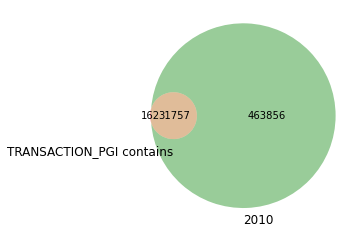

In [46]:
# Use the venn2 function
venn2(subsets = (162, 463856 , 31757), set_labels = ('TRANSACTION_PGI contains', cycle_yr, 'TRANSACTION_DT in', cycle_yr ,'cycle date range'))
plt.show()
# I wonder what is the transaction_dt range and distribution for records where transaction_pgi contains 2020, and how far off it is from the 2020 election cycle.
    # Improvement idea 2) b) Investigate this to see if it can help me get the correct dates.

In [47]:
cy10fr10v2 = pd.concat([cy10fr10, dates_in_2010cyc_fr2010])
# Drop duplicates from the concatenated dataset
cy10fr10v2.drop_duplicates(subset=['SUB_ID'], inplace=True)

In [48]:
# First, vertically concatenate the two dataframes
# then save the result to a csv
# check the number of rows in cy18fr16 and cy18fr18
print('Shape for', cycle_yr ,'election cycle transactions from', str(int(cycle_yr)-2), ': ', str(explicitly_incycle_data_additv2.shape))
print('Shape for', cycle_yr ,'election cycle transactions from', cycle_yr,': ', str(cy10fr10v2.shape))
print('There should be', explicitly_incycle_data_additv2.shape[0]+cy10fr10v2.shape[0], 'rows total for', cycle_yr, 'election cycle transactions.' )

Shape for 2010 election cycle transactions from 2008 :  (29329, 21)
Shape for 2010 election cycle transactions from 2010 :  (495775, 21)
There should be 525104 rows total for 2010 election cycle transactions.


In [49]:
fec_cy2010 = pd.concat([explicitly_incycle_data_additv2, cy10fr10v2], ignore_index=True)
fec_cy2010

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM  \
0       C00385526         A     Q3               O  29020380929   
1       C00385526         A     Q3               O  29020380929   
2       C00167684         N     YE             NaN  28930097710   
3       C90009861         A     YE               P  28039600454   
4       C90004466         N     YE               P  28039630916   
...           ...       ...    ...             ...          ...   
525099  C00341891         A     Q1               G  10020221176   
525100  C00341891         A     Q1             NaN  10020221167   
525101  C00341891         A     Q1               G  10020221167   
525102  C00341891         A     Q1               G  10020221167   
525103  C30001754         N     24               P  10931493235   

       TRANSACTION_TP ENTITY_TP                             NAME  \
0                 18G       NaN  2009 SENATORS CLASSIC COMMITTEE   
1                 18G       NaN  2009 SENATORS CLASSIC COMMITTEE   
2                 24K       ORG    PETE DOMENICI SENATE CAMPAIGN   
3                 24E       IND                      JONES, GWEN   
4                 24E       NaN              KD MAILING SERVICES   
...               ...       ...                              ...   
525099            15J       IND              FRIEDHEIM, CRYRUS F   
525100            18G       NaN           MCCAIN LEADERSHIP FUND   
525101            15J       IND                CANNON, SUE M MRS   
525102            15J       IND                CANNON, SUE M MRS   
525103             29       ORG          THE NEW MEDIA FIRM INC.   

                    CITY STATE  ...                       EMPLOYER OCCUPATION  \
0             ALEXANDRIA    VA  ...                            NaN        NaN   
1             ALEXANDRIA    VA  ...                            NaN        NaN   
2            ALBUQUERQUE    NM  ...                            NaN        NaN   
3          SAN FRANCISCO    CA  ...                            NaN        NaN   
4            LINCOLNWOOD    IL  ...                            NaN        NaN   
...                  ...   ...  ...                            ...        ...   
525099  NORTH PALM BEACH    FL  ...  CHIQUITA BRANDS INTERNATIONAL        CEO   
525100         ARLINGTON    VA  ...                            NaN        NaN   
525101          LAKEWOOD    CO  ...                        RETIRED    RETIRED   
525102          LAKEWOOD    CO  ...                        RETIRED    RETIRED   
525103        WASHINGTON    DC  ...                            NaN        NaN   

       TRANSACTION_DT TRANSACTION_AMT   OTHER_ID           TRAN_ID FILE_NUM  \
0          2009-09-30          2382.0  C00461152  SA10290748101739   438384   
1          2009-09-30         14277.0  C00461152  SA10290748101740   438384   
2          2008-12-31         -1000.0  C00202648       80124.C3613   317142   
3          2008-12-06          5000.0  P80000748    F5702041111086   321138   
4          2008-12-20          1437.0  S6IL00151    F5702141055082   322310   
...               ...             ...        ...               ...      ...   
525099     2010-03-31          2400.0        NaN  SA04270752103478   465733   
525100     2010-03-31          1938.0  C00458802  SA04270752103451   465733   
525101     2010-03-31           300.0        NaN  SA04270752103452   465733   
525102     2010-03-31          1500.0        NaN  SA04270752103453   465733   
525103     2010-10-13         99970.0  S0CO00237        F93.000001   501506   

       MEMO_CD                                          MEMO_TEXT  \
0            X  TRANSFERS FROM AFFIL./AUTH. NOTE: MEMOED 2ND Q...   
1            X  TRANSFERS FROM AFFIL./AUTH. NOTE: MEMOED ON 2N...   
2          NaN                                                NaN   
3          NaN                                                NaN   
4          NaN                                                NaN   
...        ...                                      

Now that I have the itoth data from the 2016 election cycle, I'm going to extract it to the relevant records, which is those with (transaction_tp = '24Z') and (entity_tp<>'IND' or entity_tp is null). <br>
Then, I will extract the first digits of the transaction amounts into their own column.

In [50]:
fec_cy2010_ctc = fec_cy2010[(fec_cy2010["TRANSACTION_TP"]=='24Z') & ((fec_cy2010["ENTITY_TP"]!='IND') | (fec_cy2010["ENTITY_TP"].isnull()))] 

In [51]:
# Extract the first digits of transaction_amt
fec_cy2010_ctc = fec_cy2010_ctc.assign(amt_firstdig=fec_cy2010_ctc['TRANSACTION_AMT'].astype(str).str[:1].values)
fec_cy2010_ctc[['TRANSACTION_AMT', 'amt_firstdig']]

TRANSACTION_AMT amt_firstdig
24               2000.0            2
309              2000.0            2
383              1220.0            1
387               350.0            3
388               275.0            2
...                 ...          ...
523231           7203.0            7
523232           3508.0            3
523233           3148.0            3
523234          21600.0            2
524454           5000.0            5

[7399 rows x 2 columns]

In [52]:
# drop those where transaction_amt not in [1,9], eg. if it's 0 or negative
firstdigitslist = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
fec_cy2010_ctc = fec_cy2010_ctc[fec_cy2010_ctc['amt_firstdig'].isin(firstdigitslist)]

In [53]:
if save_result == 1:
    fec_cy2010_ctc.to_csv('FEC-itoth-'+ cycle_yr +'cycle-ctc-inkind.csv', sep = '|', index = False)